# Building a Geomechanical Model from Leak-Off Tests (LOT's)

Use a stress polygon diagram to construct a geomechanical model from Leak-Off Tests (LOT's)

In [172]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

## CASE 1

## Part 1: Constraining SHmax from Leak-Off Tests (LOTs)

In [173]:
#  Key Input variables - this is the only section that requires inputs
Depth = 5600  # (ft)
Sv = 6060     # (psi)
Shmin_measurement = 3856  # (psi)
Pp = 2915     # (psi)
ΔP = 825      # (psi) 
UCS = 22000   # (psi)
μ = 0.67      # Coefficient of sliding friction
wBO = 0       # Width of Wellbore Breakout (expressed as an angle), setting this value to 0
T0 = 0        # (psi/ft). Rock tensile strength. Rocks are very weak in tension.
σΔT = 0       # That means no thermal stresses

In [174]:
# Reformulating the Frictional Faulting Theory equation for S1 (maximum stress) and S3 (minimum stress:
# S1 = fμ * (S3 - Pp) + Pp
# S3 = ((S1 - Pp) / fμ) + Pp
fμ = ((μ**2+1)**0.5+μ)**2    # Coefficient ratio of sliding friction
print('fμ =', fμ)

# Determine S1 - Maximum Stress
S3a = Sv     # Set S3a to be Sv
S1 = fμ * (S3a - Pp) + Pp
print('Maximum Stress (S1) =',S1, 'psi')

# Determine S3 - Minimum Stress
S1a = Sv     # Set S1a to be Sv
S3 = ((S1a - Pp) / fμ) + Pp
print('Minimum Stress (S3) =', S3, 'psi')

fμ = 3.5107615122500606
Maximum Stress (S1) = 13956.34495602644 psi
Minimum Stress (S3) = 3810.8170439735613 psi


## Part 2: Calculate stress magnitude constraints for each faulting regime

Use frictional faulting theory relationships to calculate the stress magnitude constraints for each faulting regime in units of psi.

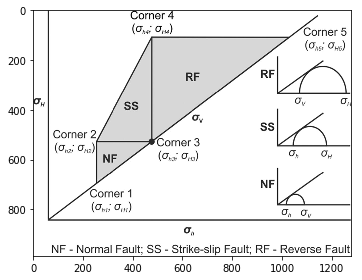

In [175]:
from skimage import io

io.imshow(io.imread("https://sp.lyellcollection.org/content/specpubgsl/458/1/273/F4.large.jpg"))
io.show()

In [176]:
# Need 5 sets of points zig zagging from bottom left to top right of the figure above.
Corner1 = [S3, S3]
Corner2 = [S3, Sv]
Corner3 = [Sv, Sv]
Corner4 = [Sv, S1]
Corner5 = [S1, S1]
print(Corner1, Corner2, Corner3, Corner4, Corner5)

[3810.8170439735613, 3810.8170439735613] [3810.8170439735613, 6060] [6060, 6060] [6060, 13956.34495602644] [13956.34495602644, 13956.34495602644]


In [177]:
# Based on the diagram above, here are the Shmin and Shmax lists
Sh_min = [S3, S3, Sv, Sv, S1]
SH_max = [S3, Sv, Sv, S1, S1]
# Create a zipped list of tuples from above lists
x = zip(Sh_min, SH_max)
# Creating a dataframe object from a ziped list
df = pd.DataFrame(x, columns = ['Sh_min (psi)', 'SH_max (psi)'])
df

,Sh_min (psi),SH_max (psi)
0,3810.817044,3810.817044
1,3810.817044,6060.000000
2,6060.000000,6060.000000
3,6060.000000,13956.344956
4,13956.344956,13956.344956


## Part 3: Calculate stress magnitude constraints from wellbore failure observations

In [178]:
# Wellbore Breakouts inputs
thetaB = 180-wBO
cos_thetaB = np.cos(np.deg2rad(thetaB))

# Create new columns to calculate the Wellbore breakout and tensile fracture stresses in psi/ft
df['SH_max_bo (psi)'] = ((UCS+2*Pp+ΔP+σΔT)-(df['Sh_min (psi)']*(1+2*cos_thetaB))) / (1-2*cos_thetaB)

# df['Shmax_bo (psi)'] =  ((Ceff+ 2 * Pp + ΔP) + df['Sh_min (psi)']) / 3
df['SH_max_tf (psi)'] = Shmax_tf = 3*df['Sh_min (psi)'] - 2*Pp - ΔP - T0 - σΔT
df

,Sh_min (psi),SH_max (psi),SH_max_bo (psi),SH_max_tf (psi)
0,3810.817044,3810.817044,10821.939015,4777.451132
1,3810.817044,6060.000000,10821.939015,4777.451132
2,6060.000000,6060.000000,11571.666667,11525.000000
3,6060.000000,13956.344956,11571.666667,11525.000000
4,13956.344956,13956.344956,14203.781652,35214.034868


In [179]:
# Drop certain rows to only retain corner points 1 & 5 - so that, a line can be drawn connecting these 2 points on the graph
df1 = df.drop(df.index[[1,2,3]])
df1

,Sh_min (psi),SH_max (psi),SH_max_bo (psi),SH_max_tf (psi)
0,3810.817044,3810.817044,10821.939015,4777.451132
4,13956.344956,13956.344956,14203.781652,35214.034868


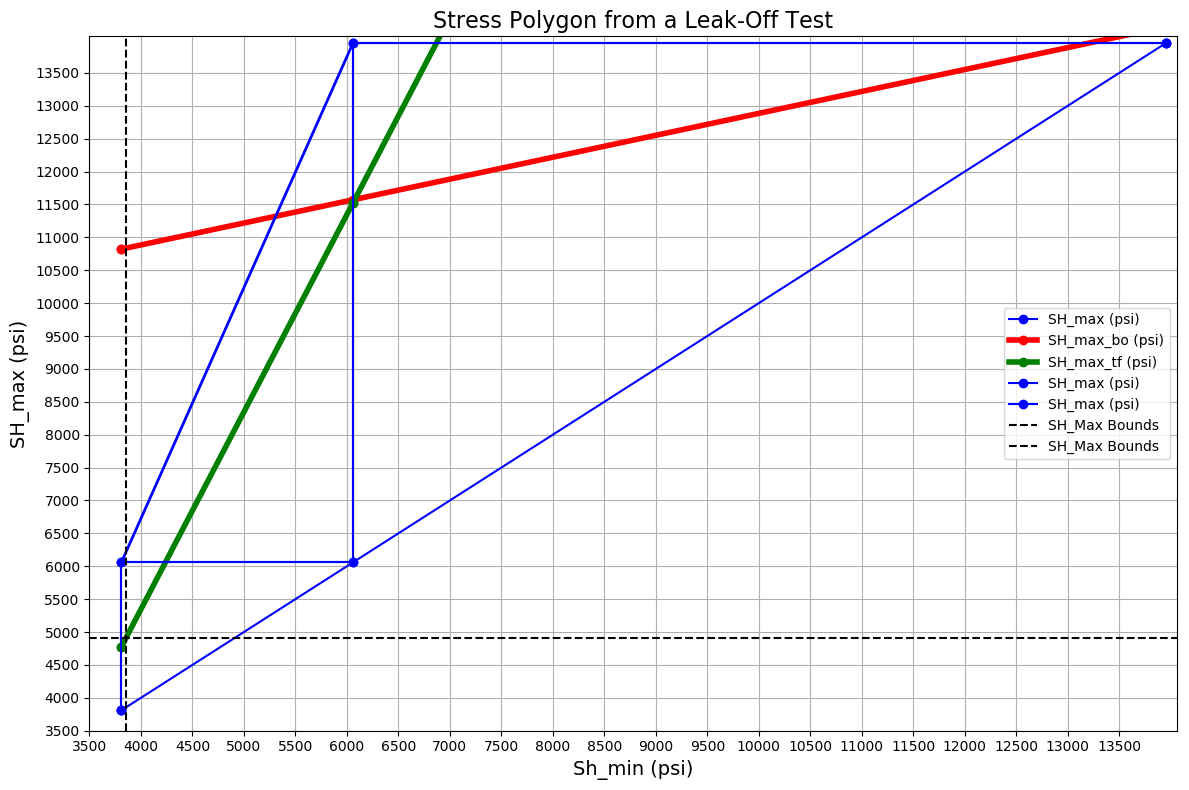

In [180]:
plt.style.use("default") 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.set_title('Stress Polygon from a Leak-Off Test', fontsize = '16')
plt.xlabel('Sh_min (psi)', fontsize = '14')
plt.ylabel('SH_max (psi)', fontsize = '14')
ax1.set_xlim(df['Sh_min (psi)'].min()-100, df['Sh_min (psi)'].max()+100)
ax1.set_ylim(df['SH_max (psi)'].min()-100, df['SH_max (psi)'].max()+100)
ax1.set_xticks(np.arange(3500, 14000, step=500))
ax1.set_yticks(np.arange(3500, 14000, step=500))
plt.tight_layout()
plt.grid()
plt.plot(df['Sh_min (psi)'], df['SH_max (psi)'], '-o', c='b')
plt.plot(df['Sh_min (psi)'], df['SH_max_bo (psi)'], '-o', c='r', linewidth=4)
plt.plot(df['Sh_min (psi)'], df['SH_max_tf (psi)'], '-o', c='g', linewidth=4)
plt.plot(df['Sh_min (psi)'], df['SH_max (psi)'], '-o', c='b')
plt.plot(df1['Sh_min (psi)'], df1['SH_max (psi)'], '-o', c='b')
plt.plot(Corner2, Corner4, 'b', linewidth=2)
plt.axvline(x=Shmin_measurement, ymax=SH_max_tf, color='k', linestyle='--', label='SH_Max Bounds')
plt.axhline(y=SH_max_tf, xmax=Shmin_measurement, color='k', linestyle='--', label='SH_Max Bounds')
plt.legend()
plt.show()

In [181]:
# What is the lower bound on SHmax at 5600 ft depth?
Sh_min = Shmin_measurement  # (psi)
print('The lower bound on SHmax at 5600 ft depth =', Sh_min, 'psi')

The lower bound on SHmax at 5600 ft depth = 3856 psi


In [182]:
# What is the upper bound on SHmax at 5600 ft depth?
SH_max_tf = (3*Shmin_measurement) - 2*Pp - ΔP - T0 - σΔT  # where it intersects the green line
print('The upper bound on SHmax at 5600 ft depth =', SH_max_tf, 'psi')

The upper bound on SHmax at 5600 ft depth = 4913 psi


## CASE 2

## Part 1: Constraining SHmax from Leak-Off Tests (LOTs)¶

In [183]:
#  Key Input variables - this is the only section that requires inputs
Depth = 7200  # (ft)
Sv = 7720     # (psi)
Shmin_measurement = 7600  # (psi)
Pp = 3710     # (psi)
ΔP = 1050     # (psi)
UCS = 28000   # (psi)
μ = 0.67      # Coefficient of sliding friction
wBO = 0       # Width of Wellbore Breakout (expressed as an angle), setting this value to 0
T0 = 0        # (psi/ft). Rock tensile strength. Rocks are very weak in tension.
σΔT = 0       # That means no thermal stresses

In [184]:
# Reformulating the Frictional Faulting Theory equation for S1 and S3:
# S1 = fμ * (S3 - Pp) + Pp
# S3 = ((S1 - Pp) / fμ) + Pp
fμ = ((μ**2+1)**0.5+μ)**2    # Coefficient ratio of sliding friction
print('fμ =', fμ)

# Determine S1 - Maximum Stress
S3a = Sv     # Set S3 to be Sv
S1 = fμ * (S3a - Pp) + Pp
print('Maximum Stress (S1) =',S1, 'psi')

# Determine S3 - Minimum Stress
S1a = Sv     # Set S1 to be Sv
S3 = ((S1a - Pp) / fμ) + Pp
print('Minimum Stress (S3) =', S3, 'psi')

fμ = 3.5107615122500606
Maximum Stress (S1) = 17788.153664122743 psi
Minimum Stress (S3) = 4852.202335877259 psi


## Part 2: Calculate stress magnitude constraints for each faulting regime

Use frictional faulting theory relationships from Homework 4 (lecture 6, slide 29) to 
calculate the stress magnitude constraints for each faulting regime in units of psi

In [185]:
# Need 5 sets of points zig zagging from bottom left to top right of the figuer above.
Corner1 = [S3, S3]
Corner2 = [S3, Sv]
Corner3 = [Sv, Sv]
Corner4 = [Sv, S1]
Corner5 = [S1, S1]
print(Corner1, Corner2, Corner3, Corner4, Corner5)

[4852.202335877259, 4852.202335877259] [4852.202335877259, 7720] [7720, 7720] [7720, 17788.153664122743] [17788.153664122743, 17788.153664122743]


In [186]:
# Based on the diagram above, here are the Shmin and Shmax lists
Sh_min = [S3, S3, Sv, Sv, S1]
SH_max = [S3, Sv, Sv, S1, S1]
# Create a zipped list of tuples from above lists
x = zip(Sh_min, SH_max)
# Creating a dataframe object from a ziped list
df = pd.DataFrame(x, columns = ['Sh_min (psi)', 'SH_max (psi)'])
df

,Sh_min (psi),SH_max (psi)
0,4852.202336,4852.202336
1,4852.202336,7720.000000
2,7720.000000,7720.000000
3,7720.000000,17788.153664
4,17788.153664,17788.153664


## Part 3: Calculate stress magnitude constraints from wellbore failure observations

Use relationships for wellbore stress magnitudes (Lecture 9, slide 23) to calculate the
stress magnitude constraints in units of psi/ft

In [187]:
# Wellbore Breakouts inputs
thetaB = 180-wBO
cos_thetaB = np.cos(np.deg2rad(thetaB))

# Create new columns to calculate the Wellbore breakout and tensile fracture stresses in psi/ft
df['SH_max_bo (psi)'] = ((UCS+2*Pp+ΔP+σΔT)-(df['Sh_min (psi)']*(1+2*cos_thetaB))) / (1-2*cos_thetaB)
df['SH_max_tf (psi)'] = Shmax_tf = 3*df['Sh_min (psi)'] - 2*Pp - ΔP - T0 - σΔT
df

,Sh_min (psi),SH_max (psi),SH_max_bo (psi),SH_max_tf (psi)
0,4852.202336,4852.202336,13774.067445,6086.607008
1,4852.202336,7720.000000,13774.067445,6086.607008
2,7720.000000,7720.000000,14730.000000,14690.000000
3,7720.000000,17788.153664,14730.000000,14690.000000
4,17788.153664,17788.153664,18086.051221,44894.460992


In [188]:
# Drop certain rows to only retain corner points 1 & 5 - so that, a line can be drawn connecting these 2 points on the graph
df1 = df.drop(df.index[[1,2,3]])
df1

,Sh_min (psi),SH_max (psi),SH_max_bo (psi),SH_max_tf (psi)
0,4852.202336,4852.202336,13774.067445,6086.607008
4,17788.153664,17788.153664,18086.051221,44894.460992


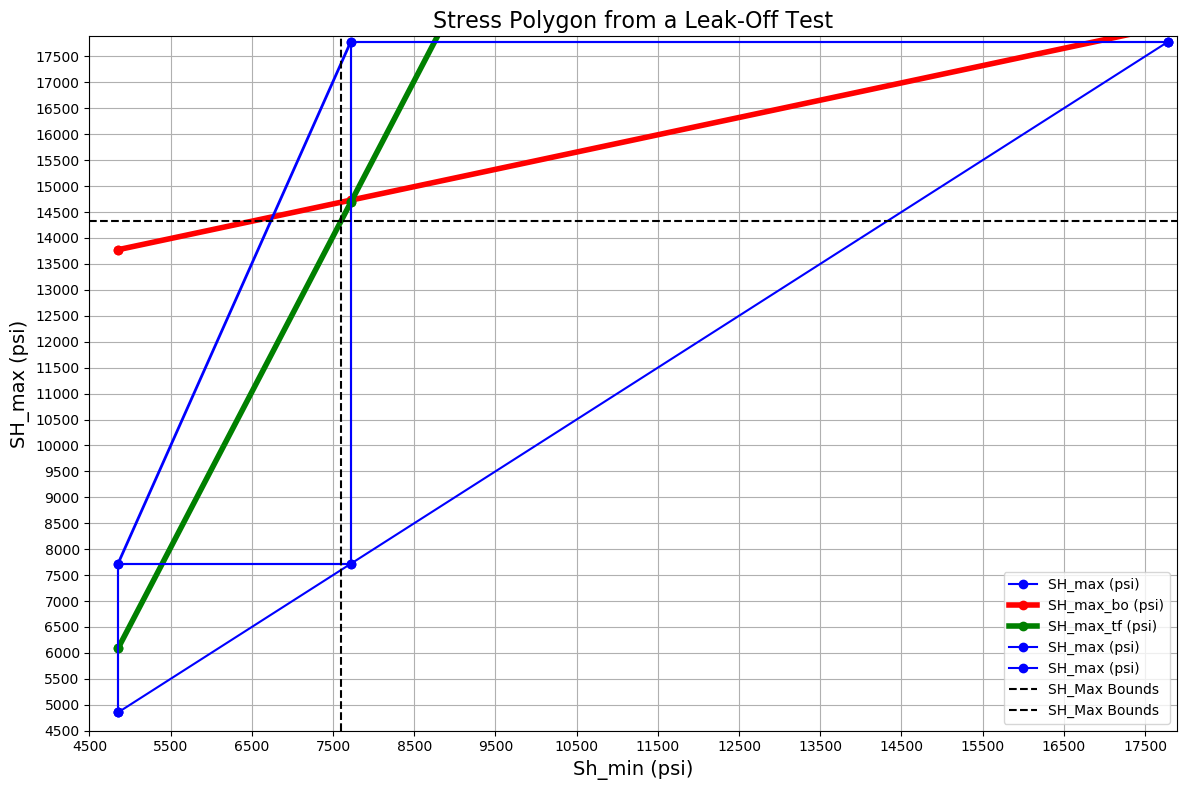

In [189]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
ax1.set_title('Stress Polygon from a Leak-Off Test', fontsize = '16')
plt.xlabel('Sh_min (psi)', fontsize = '14')
plt.ylabel('SH_max (psi)', fontsize = '14')
ax1.set_xlim(df['Sh_min (psi)'].min()-100, df['Sh_min (psi)'].max()+100)
ax1.set_ylim(df['SH_max (psi)'].min()-100, df['SH_max (psi)'].max()+100)
ax1.set_xticks(np.arange(4500, 18000, step=1000))
ax1.set_yticks(np.arange(4500, 18000, step=500))
plt.tight_layout()
plt.grid()
plt.plot(df['Sh_min (psi)'], df['SH_max (psi)'], '-o', c='b')
plt.plot(df['Sh_min (psi)'], df['SH_max_bo (psi)'], '-o', c='r', linewidth=4)
plt.plot(df['Sh_min (psi)'], df['SH_max_tf (psi)'], '-o', c='g', linewidth=4)
plt.plot(df['Sh_min (psi)'], df['SH_max (psi)'], '-o', c='b')
plt.plot(df1['Sh_min (psi)'], df1['SH_max (psi)'], '-o', c='b')
plt.plot(Corner2, Corner4, 'b', linewidth=2)
plt.axvline(x=Shmin_measurement, ymax=SHmax_tf, color='k', linestyle='--', label='SH_Max Bounds')
plt.axhline(y=SHmax_tf, xmax=Shmin_measurement, color='k', linestyle='--', label='SH_Max Bounds')
plt.legend(loc=4)
plt.show()

In [190]:
# What is the lower bound on SHmax at 7200 ft depth?
Sh_min = Shmin_measurement  # (psi)
print('The lower bound on SHmax at 7200 ft depth =', Sh_min, 'psi')

The lower bound on SHmax at 7200 ft depth = 7600 psi


In [191]:
# What is the upper bound on SHmax at 7200 ft depth?
SHmax_tf = (3*Shmin_measurement) - 2*Pp - ΔP - T0 - σΔT  # green line
print('The upper bound on SHmax at 7200 ft depth =', SHmax_tf, 'psi')

The upper bound on SHmax at 7200 ft depth = 14330 psi
